In [3]:
import sys
sys.path.append('../../FGTD/scripts')

In [4]:
!pip install -r /scratch/mnk2978/DL/MINIPROJ3/text2face/requirements.txt

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [5]:
import wandb
wandb.init(project="text-to-face2", name="n-sagan2")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mrunal (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


# Import dependencies

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.nn import Parameter
from torch.optim.optimizer import Optimizer, required

from dataclasses import dataclass, asdict
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
import random

In [7]:
from dataset import get_weighted_dataloader
from extract_zip import extract_zip
from sentence_encoder import SentenceEncoder

## Initializing helper functions

In [8]:
def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

## Initializing constants

In [9]:
@dataclass
class Config:
    epochs: int = 20
    batch_size: int = 16
    subset_size: int = 20_000

    noise_size: int = 100
    feature_size: int = 64
    image_size: int = 128
    save_epoch: int = 1
    num_channels: int = 3
    attention: bool = True
    
    embedding_dim: int = 768
    reduced_embedding_dim: int = 256

    g_lr: float = 0.0002
    d_lr: float = 0.0002

    device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [10]:
cfg = Config()
cfg_dict = asdict(cfg)
wandb.config.update(cfg_dict)

# Extracting the Dataset

You can download the dataset from Kaggle - https://www.kaggle.com/jessicali9530/celeba-dataset

Or from https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

In [11]:
# File Constants
ZIP_PATH = "/scratch/mnk2978/DL/MINIPROJ3/dataset"
OUTPUT_DIR = "/scratch/mnk2978/DL/MINIPROJ3/dataset/img_align_celeba/img_align_celeba"

In [ ]:
extract_zip(ZIP_PATH, OUTPUT_DIR)

# Create Sentence Encoder

In [12]:
sentence_encoder = SentenceEncoder(cfg.device)

Some weights of the model checkpoint at /home/mnk2978/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Create Custom Dataset Reader

In [13]:
class ImageNTextDataset(torch.utils.data.Dataset):
    """
    Meant for CelebA Dataset'.
    Pairs True Image, True Text and Wrong Image
    """

    def __init__(self, root_dir, csv_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.text_df = pd.read_csv(csv_file)
        self.length = len(self.text_df)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.text_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Real Images
        img_name = os.path.join(self.root_dir, self.text_df.iloc[idx, 0])
        image = Image.open(img_name)

        true_text = random.choice(self.text_df.iloc[idx, 1:].values[0].split('\n')).strip()

        if self.transform:
            true_image = self.transform(image)

        # Wrong Images
        wrong_idx = random.randint(0, self.length - 1)
        while wrong_idx == idx:
            # To get a different index incase it is same
            wrong_idx = random.randint(0, self.length - 1)
        wrong_img_name = os.path.join(self.root_dir, self.text_df.iloc[wrong_idx, 0])
        wrong_image = Image.open(wrong_img_name)

        if self.transform:
            wrong_image = self.transform(wrong_image)

        return true_image, true_text, wrong_image

In [14]:
n_caption_dataset = ImageNTextDataset(
    root_dir=OUTPUT_DIR, 
    csv_file='/scratch/mnk2978/DL/MINIPROJ3/text2face/dataset/text_5_descr_celeba.csv',
    transform=transforms.Compose([transforms.Resize((cfg.image_size, cfg.image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]),
)

# Create DataLoader

In [15]:
weighted_dataloader, weighted_dataiter = get_weighted_dataloader(
    '/scratch/mnk2978/DL/MINIPROJ3/text2face/dataset/list_attr_celeba.csv',  
    custom_dataset=n_caption_dataset,
    batch_size=cfg.batch_size,
    subset_size=cfg.subset_size
)

Length of random indices: 20000
Classes present:  {'Young', 'Smiling', 'Pointy_Nose', 'Wearing_Hat', 'Big_Lips', 'Eyeglasses', 'Male', 'Attractive', 'Straight_Hair', 'Wearing_Necklace', 'Oval_Face', 'Brown_Hair', 'Big_Nose', 'Goatee', 'Wavy_Hair', 'Wearing_Earrings', 'Receding_Hairline', 'Heavy_Makeup', 'Wearing_Necktie', 'Black_Hair', 'Wearing_Lipstick', 'Pale_Skin', 'Narrow_Eyes', 'Bald', 'Bushy_Eyebrows', 'High_Cheekbones', 'Gray_Hair', 'Mouth_Slightly_Open', 'Mustache', '5_o_Clock_Shadow', 'Double_Chin', 'Rosy_Cheeks', 'Sideburns', 'Blond_Hair', 'Arched_Eyebrows', 'Chubby'}
Number of classes:  36
Length of subset dataset: 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Using Custom Dataset Loader...


## Testing DataLoader output

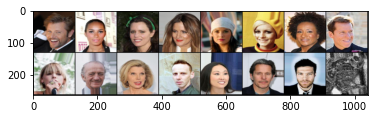

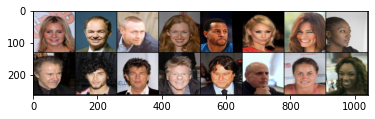

["The gentleman has high cheekbones. He grows a 5 o' clock shadow. His hair is brown and straight. He has a slightly open mouth. The man looks attractive and young is smiling.", 'The lady has an oval face. She has straight and receding hair. She has arched eyebrows, big lips, a big nose, bushy eyebrows and a slightly open mouth. The female is attractive, young, has heavy makeup and rosy cheeks. She is wearing earrings and lipstick.', 'The woman has high cheekbones and an oval face. Her hair is wavy. She has a slightly open mouth. The female is smiling, seems attractive, young and has heavy makeup. She is wearing lipstick.', 'The female has pretty high cheekbones. She is attractive, young, is smiling and has heavy makeup. She is wearing lipstick.', 'The lady looks attractive, young and has heavy makeup. She is wearing a hat and lipstick.', 'The female has pretty high cheekbones. She has blond and straight hair. She has big lips and a slightly open mouth. The female is smiling, looks att

In [16]:
images, labels, wrong_images = weighted_dataiter.next()
show_grid(torchvision.utils.make_grid(images, normalize=True))
show_grid(torchvision.utils.make_grid(wrong_images, normalize=True))
print(labels)

## Creating BERT sent embeddings

In [17]:
output = sentence_encoder.convert_text_to_embeddings(labels)
print(output)
print(output.shape)

tensor([[ 0.2682,  0.0620,  0.4319,  ...,  0.4810,  0.4043, -0.2342],
        [ 0.3268, -0.1512, -0.0175,  ..., -0.2796,  0.2058,  0.0353],
        [ 0.2177, -0.4683,  0.2138,  ..., -0.5245, -0.0446,  0.1968],
        ...,
        [ 0.4994,  0.3842,  0.7407,  ...,  0.1032,  0.1999, -0.0773],
        [ 0.3948, -0.3736,  0.3723,  ...,  0.4639,  0.1052, -0.2596],
        [ 0.4785,  0.0026,  1.3073,  ...,  0.1208, -0.1483, -0.2505]],
       device='cuda:0')
torch.Size([16, 768])


## Initialize weights

In [18]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

## Defining Attention Module

In [19]:
class Self_Attn(nn.Module):
  '''
  Self attention layer
  '''
  def __init__(self, in_dim):
    super().__init__()

    self.query_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim // 2, kernel_size = 1)
    self.key_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim // 2, kernel_size = 1)
    self.value_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim, kernel_size = 1)

    self.gamma = nn.Parameter(torch.zeros(1))
    self.softmax = nn.Softmax(dim = -1)


  def forward(self, x):
    batch_size, C, width, height = x.size()
    query = self.query_conv(x).view(batch_size, -1, width * height).permute(0,2, 1)
    key = self.key_conv(x).view(batch_size, -1, width * height)
    energy = torch.bmm(query, key)

    attn = self.softmax(energy)
    value = self.value_conv(x).view(batch_size, -1, width * height)
    out = torch.bmm(value, attn.permute(0, 2, 1))
    out = out.view(batch_size, C, width, height)

    out = self.gamma * out + x
    return out, attn

In [20]:
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)

In [21]:
class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [22]:
class Generator(nn.Module):
  '''
  Generator architecture
  '''
  def __init__(self, noise_size, embedding_size, reduced_dim_size, num_channels, image_size, attn = True, feature_size = 64):
    super(Generator, self).__init__()
    self.attn = attn
    self.noise_dim = noise_size
    
    assert image_size in [64, 128, 256], "Can only generate images for 64, 128 and 256 dimensions."
    self.image_size = image_size

    ########## Embedding Layer ##########
    self.encode_layer = nn.Sequential(
        nn.Linear(embedding_size, reduced_dim_size),
        nn.BatchNorm1d(reduced_dim_size),
        nn.ReLU(),
        nn.Linear(reduced_dim_size, noise_size),
        nn.BatchNorm1d(noise_size),
        nn.ReLU(),
    )

    # Size 1 -> 4
    self.layer1 = nn.Sequential(
        SpectralNorm(nn.ConvTranspose2d(in_channels = noise_size, out_channels = feature_size*8, kernel_size = 4)),
        nn.BatchNorm2d(feature_size*8),
        nn.ReLU()
    )
    
    # Size 4 -> 8
    self.layer2 = nn.Sequential(
        SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*8, out_channels = feature_size*4, kernel_size = 4, stride = 2, padding = 1)),
        nn.BatchNorm2d(feature_size*4),
        nn.ReLU()
    )
    
    # Size 8 -> 16
    self.layer3 = nn.Sequential(
        SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*4, out_channels = feature_size*2, kernel_size = 4, stride = 2, padding = 1)),
        nn.BatchNorm2d(feature_size*2),
        nn.ReLU()
    )

    # Attn1 layer turn 128 dims -> 128 dims
    self.attn1 = Self_Attn(feature_size*2)
    
    # Size 16 -> 32
    self.layer4 = nn.Sequential(
        SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*2, out_channels = feature_size*2, kernel_size = 4, stride = 2, padding = 1)),
        nn.BatchNorm2d(feature_size*2),
        nn.ReLU()
    )
    
    # Attn2 layer turn 64 dims -> 64 dims
    self.attn2 = Self_Attn(feature_size*2)

    final_size = feature_size * 2
    
    if image_size >= 128:
        # Size 32 -> 64
        self.layer5 = nn.Sequential(
            SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*2, out_channels = feature_size*2, kernel_size = 4, stride = 2, padding = 1)),
            nn.BatchNorm2d(feature_size*2),
            nn.ReLU()
        )

        final_size = feature_size * 2

        # Attn3 layer turn 64 dims -> 64 dims
        self.attn3 = Self_Attn(feature_size*2)

        if image_size == 256:
            # Size 64 -> 128
            self.layer6 = nn.Sequential(
                SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*2, out_channels = feature_size, kernel_size = 4, stride = 2, padding = 1)),
                nn.BatchNorm2d(feature_size),
                nn.ReLU()
            )

            final_size = feature_size

        

    # Output last_dim -> last_dim * 2
    self.output_layer = nn.Sequential(
        nn.ConvTranspose2d(final_size, 3, 4, 2, 1),
        nn.Tanh()
    )

    self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.999))

  def forward(self, noise, text_embeddings):
    encoded_text = self.encode_layer(text_embeddings)
    # Concatenating the noise and encoded text
    concat_input = torch.mul(noise, encoded_text).view(-1, self.noise_dim, 1, 1)
    
    x = self.layer1(concat_input)
    x = self.layer2(x)
    x = self.layer3(x)
    if self.attn:
      x, _ = self.attn1(x)
    x = self.layer4(x)
    if self.attn:
      x, _ = self.attn2(x)
    if self.image_size >= 128:
        x = self.layer5(x)
        if self.attn:
            x, _ = self.attn3(x)
        if self.image_size == 256:
            x = self.layer6(x)
        

    x = self.output_layer(x)
    return x


In [23]:
generator = Generator(cfg.noise_size, cfg.embedding_dim, cfg.reduced_embedding_dim, cfg.num_channels, cfg.image_size, attn=cfg.attention, feature_size=cfg.feature_size)
generator.cuda()

Generator(
  (encode_layer): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    )
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

torch.Size([16, 3, 128, 128])


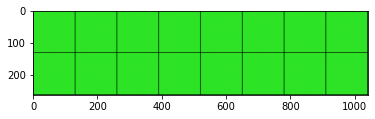

Generator(
  (encode_layer): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    )
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

In [24]:
with torch.no_grad():
  generator.eval()
  noise = torch.randn(size=(cfg.batch_size, cfg.noise_size)).cuda()
  text_embeddings = sentence_encoder.convert_text_to_embeddings(labels)
  output = generator(noise, text_embeddings).detach()
  print(output.shape)
show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))
generator.train()

In [25]:
class Discriminator(nn.Module):
  '''
  Discriminator architecture
  '''
  def __init__(self, num_channels, feature_size, attn, image_size, embedding_size, reduced_dim_size):
    super(Discriminator, self).__init__()
    self.reduced_dim_size = reduced_dim_size
    self.attn = attn
    self.image_size = image_size

    # Size 256/128/64 -> 128/64/32
    self.layer1 = nn.Sequential(
        SpectralNorm(nn.Conv2d(num_channels, feature_size, 4, 2, 1)),
        nn.LeakyReLU(0.1)
    )
    
    # Size 128/64/32 -> 64/32/16
    self.layer2 = nn.Sequential(
        SpectralNorm(nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1)),
        nn.LeakyReLU(0.1)
    )
    feature_size = feature_size * 2
    
    # Size 64/32/16 -> 32/16/8
    self.layer3 = nn.Sequential(
        SpectralNorm(nn.Conv2d(feature_size , feature_size, 4, 2, 1)),
        nn.LeakyReLU(0.1)
    )
    
    # Attn1 layer remains the same dim and size
    self.attn1 = Self_Attn(feature_size)
    
    # Size 32/16/8 -> 16/8/4
    self.layer4 = nn.Sequential(
        SpectralNorm(nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1)),
        nn.LeakyReLU(0.1)
    )
    feature_size = feature_size * 2
    
    # Attn2 layer remains the same dim and size
    self.attn2 = Self_Attn(feature_size)

    if image_size >= 128:
        # Size 16/8 -> 8/4
        self.layer5 = nn.Sequential(
            SpectralNorm(nn.Conv2d(feature_size, feature_size, 4, 2, 1)),
            nn.LeakyReLU(0.1)
        )

        self.attn3 = Self_Attn(feature_size)

        if image_size == 256:
            # Size 8 -> 4

            self.layer6 = nn.Sequential(
                SpectralNorm(nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1)),
                nn.LeakyReLU(0.1)
            )
            
            feature_size = feature_size * 2

    ########## Text Encode ##########
    self.encode_text = nn.Sequential(
        nn.Linear(embedding_size, reduced_dim_size),
        nn.LeakyReLU(0.2, inplace=True)
    )

    ########## Text + Image Concate Layer ##########
    self.image_text_layer = nn.Sequential(
        nn.Conv2d(feature_size + reduced_dim_size, feature_size * 8, 1, 1, 0, bias=False),
        nn.BatchNorm2d(feature_size * 8),
        nn.LeakyReLU(0.2,inplace=True),
    )

    ########## Output Layer ##########
    self.output_layer = nn.Sequential(
        nn.Conv2d(feature_size * 8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

    self.optimizer = optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))

  def forward(self, input_images, text_embeddings):
    x = self.layer1(input_images)
    x = self.layer2(x)
    x = self.layer3(x)
    if self.attn:
      x, _ = self.attn1(x)
    x = self.layer4(x)
    if self.attn:
      x, _ = self.attn2(x)
    if self.image_size >= 128:
        x = self.layer5(x)
        if self.attn:
            x, _ = self.attn3(x)
        if self.image_size == 256:
            x = self.layer6(x)

    ## Text ##
    encoded_text = self.encode_text(text_embeddings)
    encoded_text = encoded_text.unsqueeze(2).unsqueeze(2).repeat(1, 1, 4, 4)

    ## Text + Image ##
    concat_output = self.image_text_layer(torch.cat([x, encoded_text], dim=1))
    output = self.output_layer(concat_output)

    return output.view(-1, 1)


In [26]:
discriminator = Discriminator(cfg.num_channels, cfg.image_size, cfg.attention, cfg.image_size, cfg.embedding_dim, cfg.reduced_embedding_dim)
discriminator.cuda()

Discriminator(
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (attn1): Self_Attn(
    (query_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (layer4): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  

In [27]:
with torch.no_grad():
  discriminator.eval()
  validity = discriminator(output, text_embeddings)
  print(validity.shape)
discriminator.train()

torch.Size([16, 1])


Discriminator(
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (attn1): Self_Attn(
    (query_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (layer4): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  

## Plotting output after each epoch

In [28]:
plt_images, plt_labels, plt_wrong = weighted_dataiter.next()
plt_o_text_embeddings = sentence_encoder.convert_text_to_embeddings(plt_labels)
plt_o_text_embeddings.shape

torch.Size([16, 768])

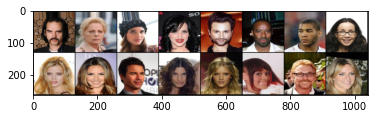

['He grows a mustache. He has black, straight and receding hair. He has a big nose and bushy eyebrows.', 'Her hair is blond, wavy and receding. She has pale skin.', 'She has wavy hair. She has arched eyebrows, big lips and bushy eyebrows. She seems attractive, young and has heavy makeup. She is wearing a hat and lipstick.', 'The female has pretty high cheekbones. She has black and wavy hair. She has big lips and a slightly open mouth. She is smiling, seems young and has heavy makeup. She is wearing lipstick.', "He has a 5 o' clock shadow, sports a goatee and has sideburns. He has a big nose and a pointy nose. The gentleman looks attractive and young.", 'The gentleman has a chubby face, has pretty high cheekbones and an oval face. He grows a goatee. He has receding hair. He has big lips and a big nose. The man looks young.', "The male has high cheekbones. He grows a 5 o' clock shadow. He has black and receding hair. He has big lips, a big nose and bushy eyebrows. The gentleman is young.

In [29]:
show_grid(torchvision.utils.make_grid(plt_images.cpu(), normalize=True))
print(plt_labels)

In [30]:
fixed_noise = torch.randn(size=(len(plt_labels), cfg.noise_size)).cuda()

In [31]:
def plot_output(epoch):
  plt.clf()
  with torch.no_grad():

    generator.eval()
    test_images = generator(fixed_noise, plt_o_text_embeddings)
    generator.train()
    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)
  
  wandb.log({'output': wandb.Image(grid, caption=f'Output for epoch: {epoch}')}, step=epoch)

## Training

In [32]:
adversarial_loss = nn.BCELoss().cuda()

0it [00:00, ?it/s]

Epoch: 1 / 20


/home/mnk2978/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/mnk2978/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1023: UserWarning: Using a non-full backward hook when outputs are generated by different autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when outputs are generated by different autograd Nodes "


Discriminator Loss: 1.921, Generator Loss: 1.852


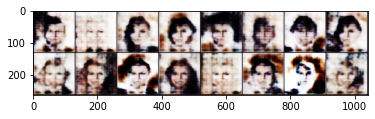

Epoch: 2 / 20
Discriminator Loss: 1.411, Generator Loss: 2.374


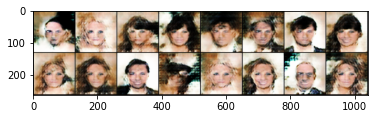

Epoch: 3 / 20
Discriminator Loss: 0.983, Generator Loss: 3.547


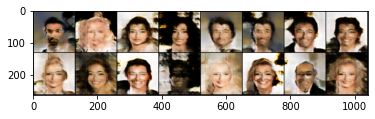

Epoch: 4 / 20
Discriminator Loss: 0.875, Generator Loss: 4.062


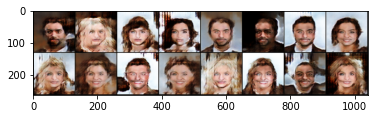

Epoch: 5 / 20
Discriminator Loss: 0.718, Generator Loss: 4.650


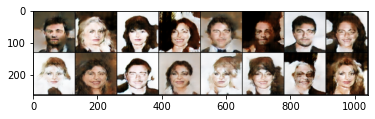

Epoch: 6 / 20
Discriminator Loss: 0.664, Generator Loss: 5.033


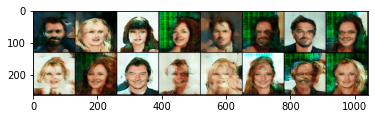

Epoch: 7 / 20
Discriminator Loss: 0.640, Generator Loss: 5.039


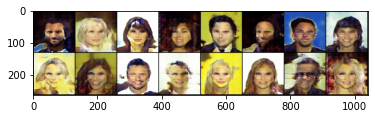

Epoch: 8 / 20
Discriminator Loss: 0.602, Generator Loss: 5.346


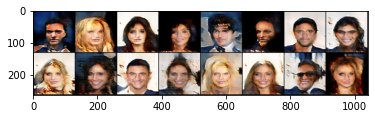

Epoch: 9 / 20
Discriminator Loss: 0.549, Generator Loss: 5.762


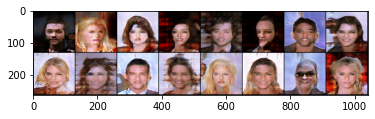

Epoch: 10 / 20


In [ ]:
pbar = tqdm()

# Add models to wandb
wandb.watch(generator)
wandb.watch(discriminator)

for epoch in range(cfg.epochs):
    print(f'Epoch: {epoch + 1} / {cfg.epochs}')
    pbar.reset(total=len(weighted_dataloader))

    # Setting up losses
    discriminator_losses = []
    generator_losses = []

    for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):

        # Current batch size
        current_batch_size = real_images.size()[0]

        # Convert to cuda
        real_images = real_images.cuda()
        wrong_images = wrong_images.cuda()
        text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)

        # For real vs fake
        real_validity = torch.ones(current_batch_size, 1).cuda()
        fake_validity = torch.zeros(current_batch_size, 1).cuda()

        # Train Generator
        generator.zero_grad()
        input_noise = torch.randn(size=(current_batch_size, cfg.noise_size)).cuda()
        fake_images = generator(input_noise, text_embeddings)
        discriminator_fake_validity = discriminator(fake_images, text_embeddings)
        generator_loss = adversarial_loss(discriminator_fake_validity, real_validity)

        generator_loss.backward()
        generator.optimizer.step()
        generator_losses.append(generator_loss)

        # Train Discriminator
        discriminator.zero_grad()

        ## To calculate real loss
        discriminator_real_validity = discriminator(real_images, text_embeddings)
        discriminator_real_loss = adversarial_loss(discriminator_real_validity, real_validity)

        ## To calculate wrong loss
        discriminator_wrong_validity = discriminator(wrong_images, text_embeddings)
        discriminator_wrong_loss = adversarial_loss(discriminator_wrong_validity, fake_validity)

        ## To calculate fake loss
        discriminator_fake_validity = discriminator(fake_images.detach(), text_embeddings)
        discriminator_fake_loss = adversarial_loss(discriminator_fake_validity, fake_validity)

        ## Calculating total loss
        discriminator_loss = discriminator_real_loss + discriminator_wrong_loss + discriminator_fake_loss
        discriminator_loss.backward()
        discriminator.optimizer.step()
        discriminator_losses.append(discriminator_loss)


        # Update tqdm
        pbar.update()

    print('Discriminator Loss: {:.3f}, Generator Loss: {:.3f}'.format(
            torch.mean(torch.FloatTensor(discriminator_losses)),
            torch.mean(torch.FloatTensor(generator_losses))
    ))
    
    wandb.log({"generator loss" : torch.mean(torch.FloatTensor(generator_losses)), "discriminator loss" : torch.mean(torch.FloatTensor(discriminator_losses))}, step=epoch+1)
    
    if (epoch + 1) % cfg.save_epoch == 0:
        plot_output(epoch+1)
        torch.save(generator.state_dict(), "./checkpoints/checkpoint_generator{}.pth".format(epoch))

pbar.refresh()

## Testing

In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(["Her hair is blond, wavy and receding. She has pale skin."])

In [ ]:
generator.eval()
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['The female has pretty high cheekbones and an oval face. Her hair is black. She has a slightly open mouth and a pointy nose. The female is smiling, looks attractive and has heavy makeup. She is wearing earrings and lipstick.'])

In [ ]:
generator.eval()
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))